# 2. Advanced Evaluation Metrics - Credit Default

**Goal:** Move beyond accuracy to examine Precision, Recall, ROC-AUC, and PR curves on real credit default data.

**Dataset:** UCI Credit Card Default (Real financial outcomes)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, 
    precision_recall_curve, average_precision_score,
    f1_score, matthews_corrcoef
)

# Load real Credit Default data
df = pd.read_excel('../data/raw/credit_card_default.xls', header=1)
df.rename(columns={'default payment next month': 'target'}, inplace=True)

X = df.drop(['ID', 'target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print(f"Class Distribution (Test Set):")
print(y_test.value_counts(normalize=True))

Class Distribution (Test Set):
target
0    0.778833
1    0.221167
Name: proportion, dtype: float64


## 1. Confusion Matrix Analysis

Understanding where the model makes errors.

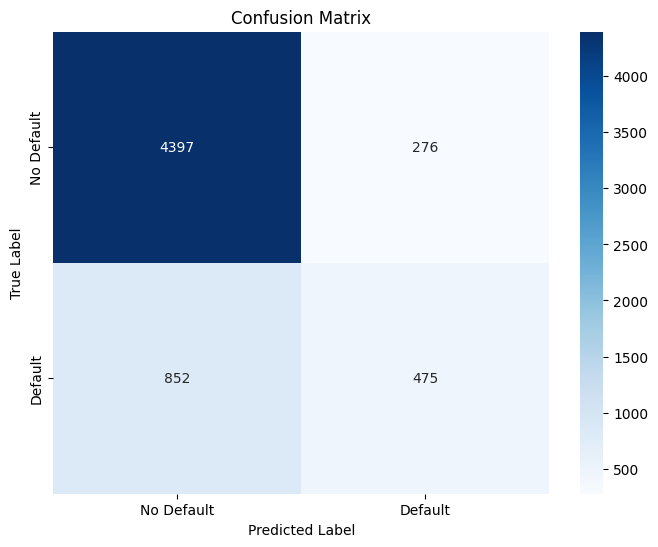


Detailed Metrics:
  True Negatives: 4397
  False Positives: 276 (Type I Error)
  False Negatives: 852 (Type II Error - Costly!)
  True Positives: 475

  Sensitivity (Recall): 0.358
  Specificity: 0.941
  Precision: 0.632


In [2]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate derived metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)
precision = tp / (tp + fp)

print(f"\nDetailed Metrics:")
print(f"  True Negatives: {tn}")
print(f"  False Positives: {fp} (Type I Error)")
print(f"  False Negatives: {fn} (Type II Error - Costly!)")
print(f"  True Positives: {tp}")
print(f"\n  Sensitivity (Recall): {sensitivity:.3f}")
print(f"  Specificity: {specificity:.3f}")
print(f"  Precision: {precision:.3f}")

## 2. Classification Report

Comprehensive per-class metrics.

In [3]:
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

# Additional metrics
print(f"\nAdditional Metrics:")
print(f"  F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"  Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred):.3f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

              precision    recall  f1-score   support

  No Default       0.84      0.94      0.89      4673
     Default       0.63      0.36      0.46      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000


Additional Metrics:
  F1 Score: 0.457
  Matthews Correlation Coefficient: 0.375
  ROC-AUC: 0.751


## 3. ROC Curve Analysis

Trade-off between True Positive Rate and False Positive Rate.

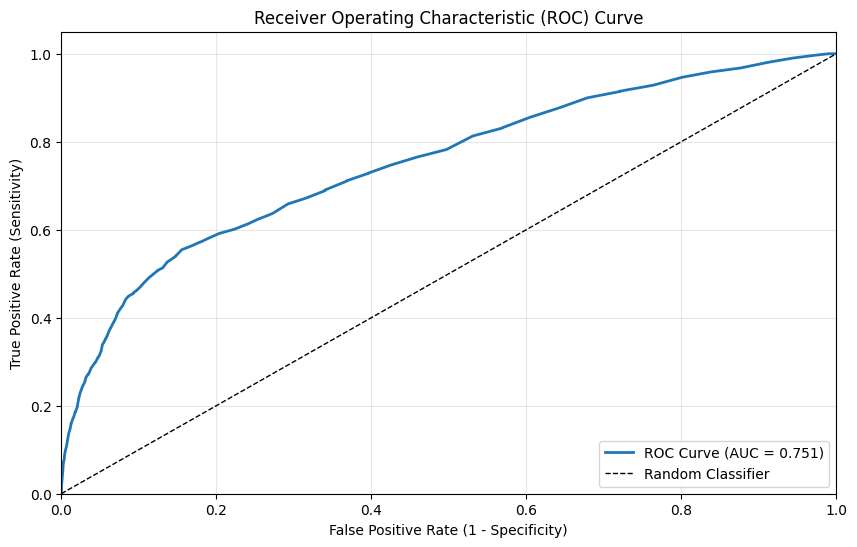


Optimal Threshold (Youden's Index): 0.310
  TPR at optimal: 0.555
  FPR at optimal: 0.156


In [4]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Find optimal threshold (Youden's Index)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = roc_thresholds[optimal_idx]
print(f"\nOptimal Threshold (Youden's Index): {optimal_threshold:.3f}")
print(f"  TPR at optimal: {tpr[optimal_idx]:.3f}")
print(f"  FPR at optimal: {fpr[optimal_idx]:.3f}")

## 4. Precision-Recall Curve

More appropriate for imbalanced datasets than ROC.

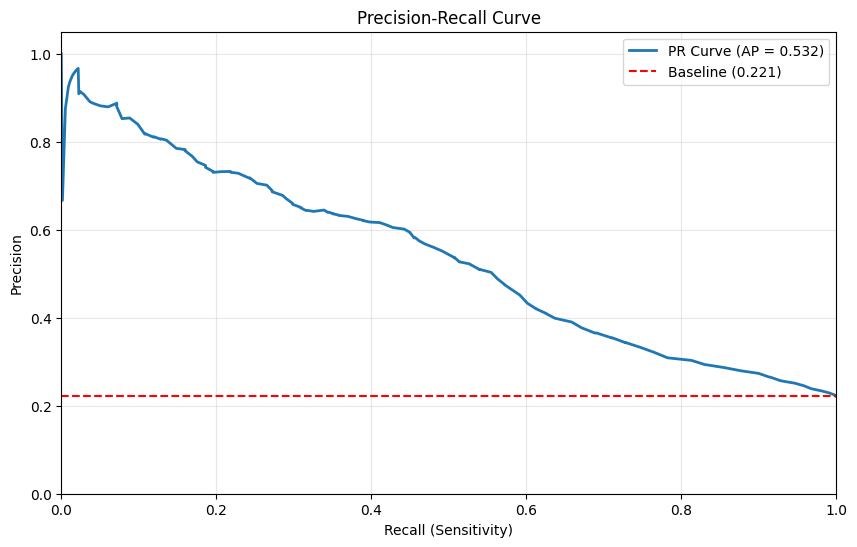


💡 Key Insight: With 22.1% default rate, we need PR curve more than ROC.


In [5]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, lw=2, label=f'PR Curve (AP = {avg_precision:.3f})')
plt.axhline(y=y_test.mean(), color='r', linestyle='--', label=f'Baseline ({y_test.mean():.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()

print(f"\n💡 Key Insight: With {y_test.mean():.1%} default rate, we need PR curve more than ROC.")

## 5. Threshold Impact Analysis

How metrics change as we adjust the decision threshold.

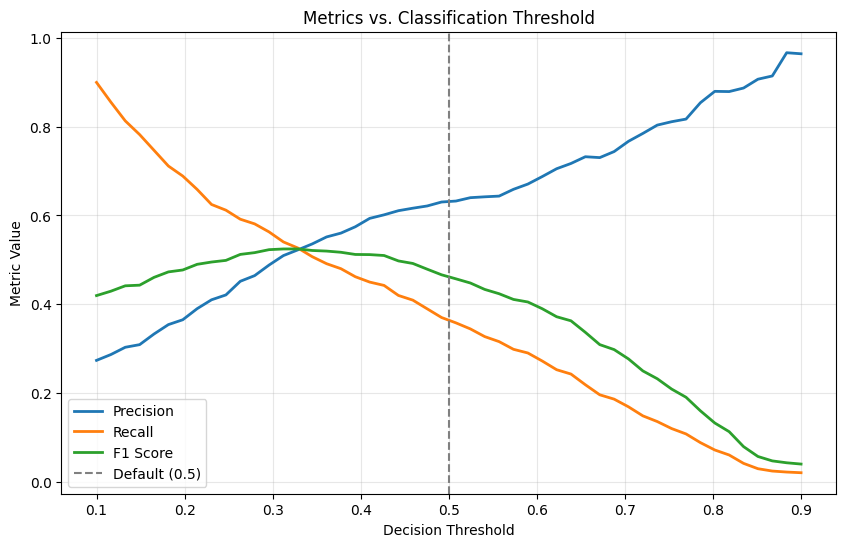


🎯 Conclusion: Moving beyond accuracy reveals the precision-recall trade-off critical for business decisions.


In [6]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1_scores.append(f1_score(y_test, y_pred_thresh))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', lw=2)
plt.plot(thresholds, recalls, label='Recall', lw=2)
plt.plot(thresholds, f1_scores, label='F1 Score', lw=2)
plt.axvline(x=0.5, color='gray', linestyle='--', label='Default (0.5)')
plt.xlabel('Decision Threshold')
plt.ylabel('Metric Value')
plt.title('Metrics vs. Classification Threshold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\n🎯 Conclusion: Moving beyond accuracy reveals the precision-recall trade-off critical for business decisions.")